Enter the stock name or ticker symbol: AAPL
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=2022, ...) : 
Short Term Training Accuracy :  0.8129249683744466
Short Term Validation Accuracy :  0.7735515258735073
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=No

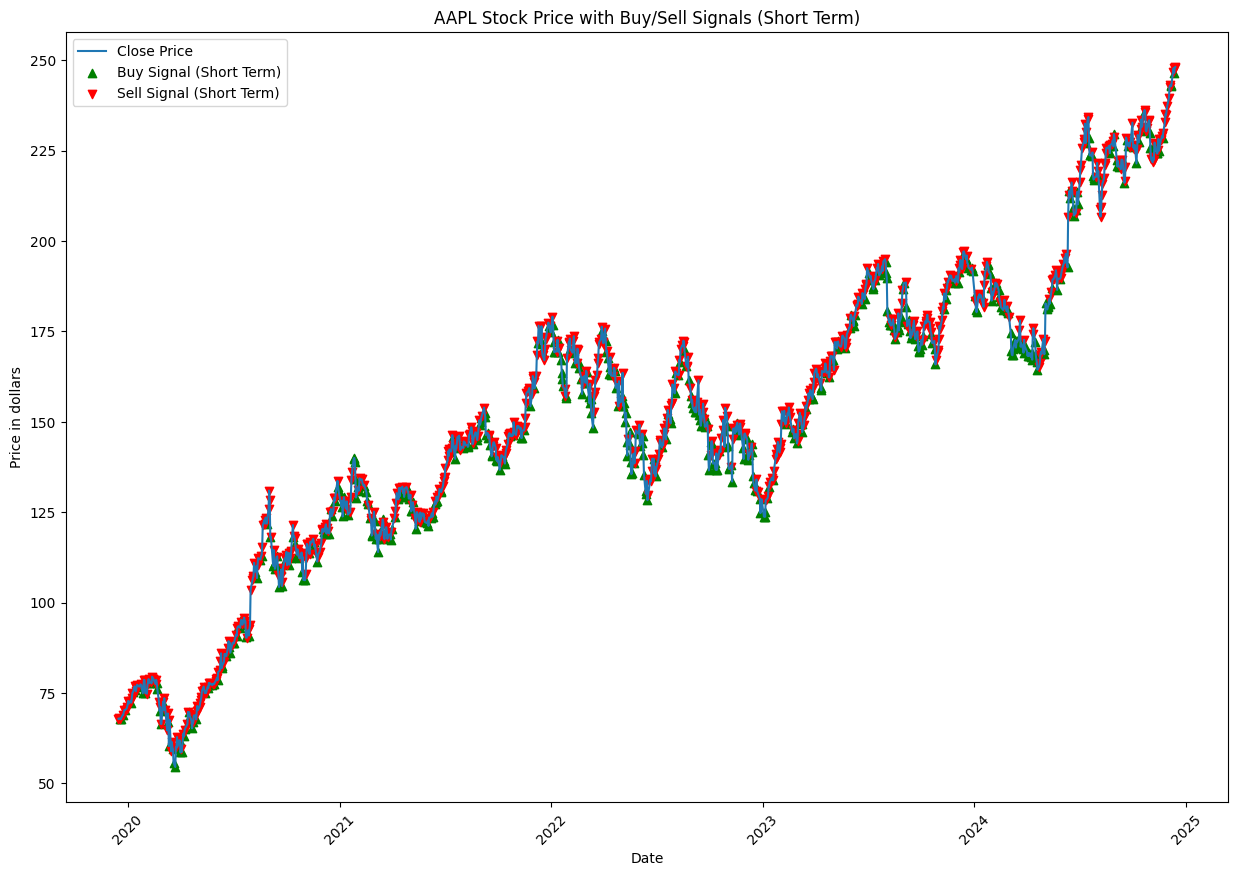

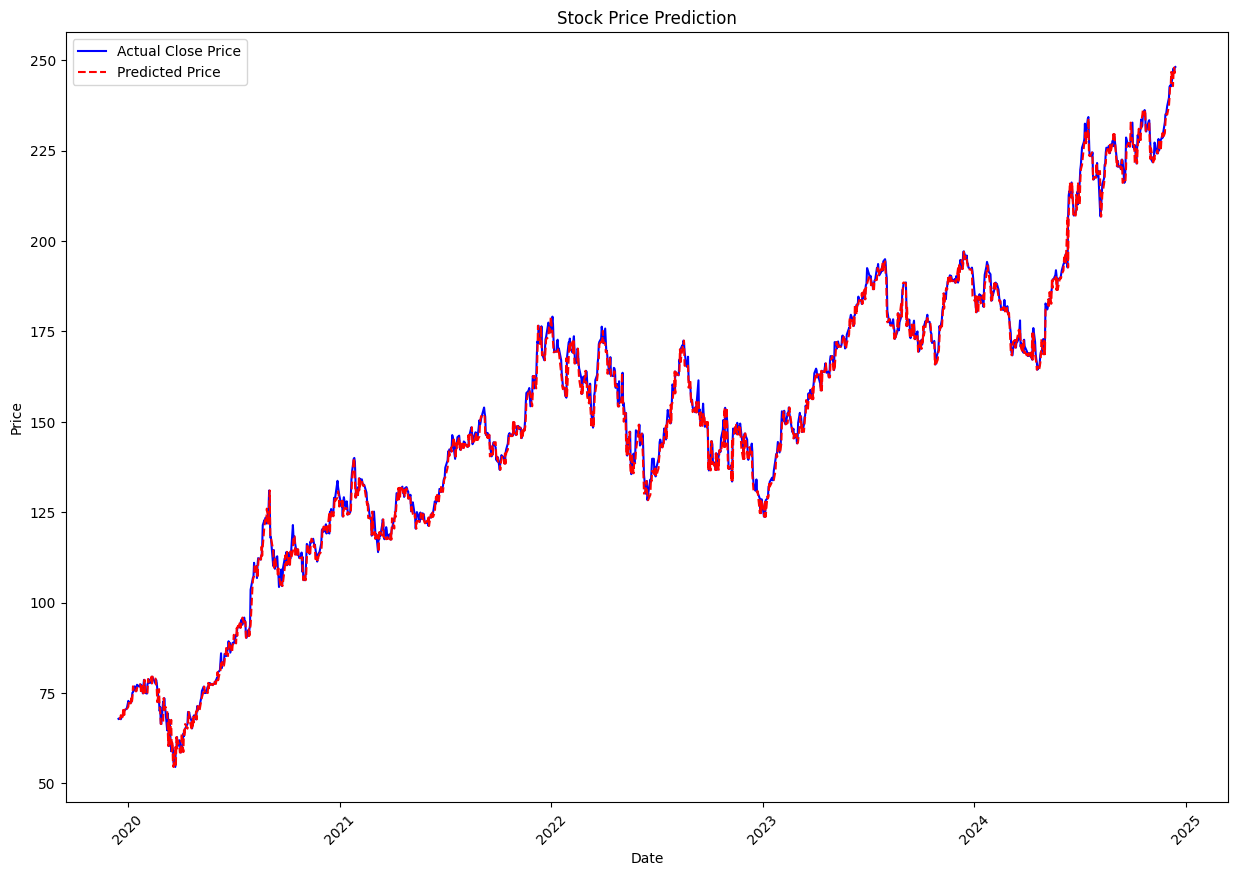

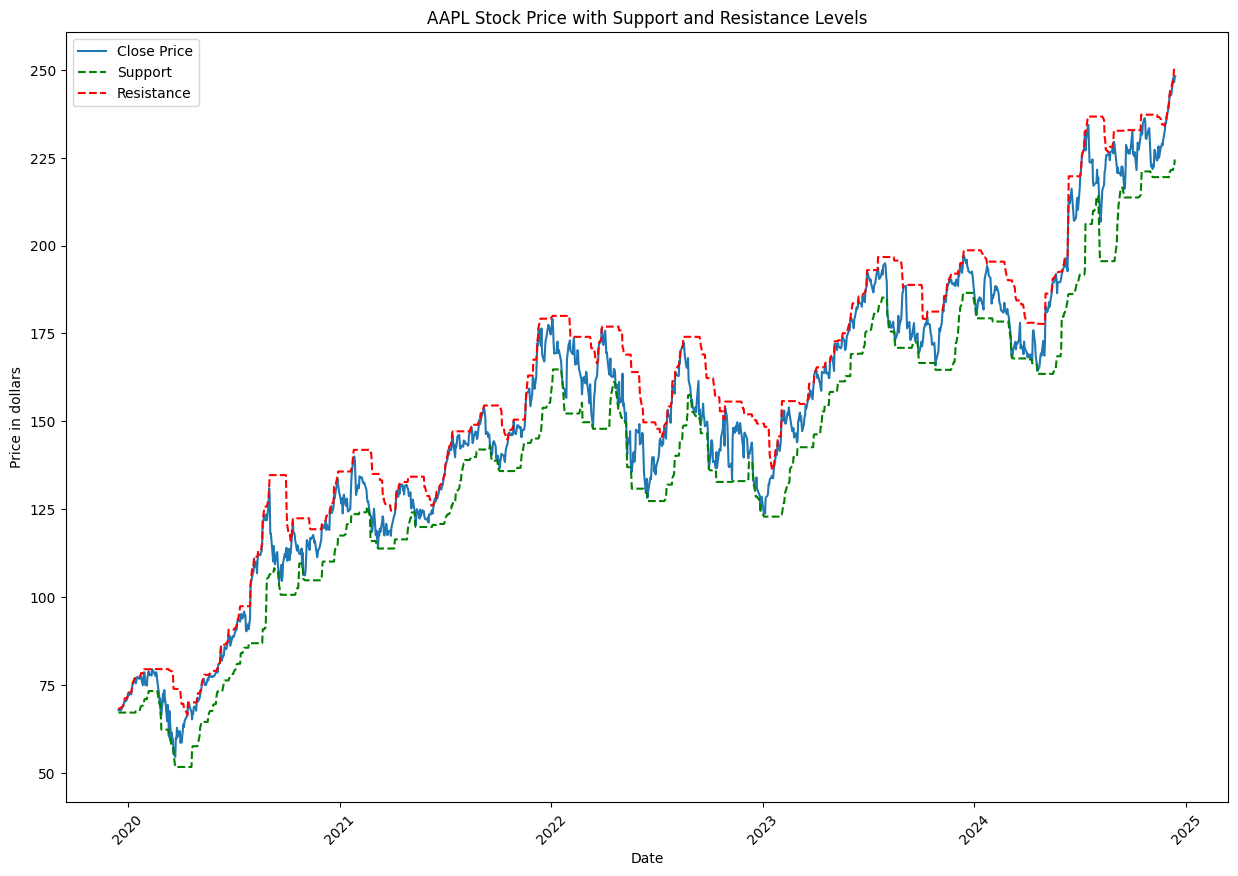

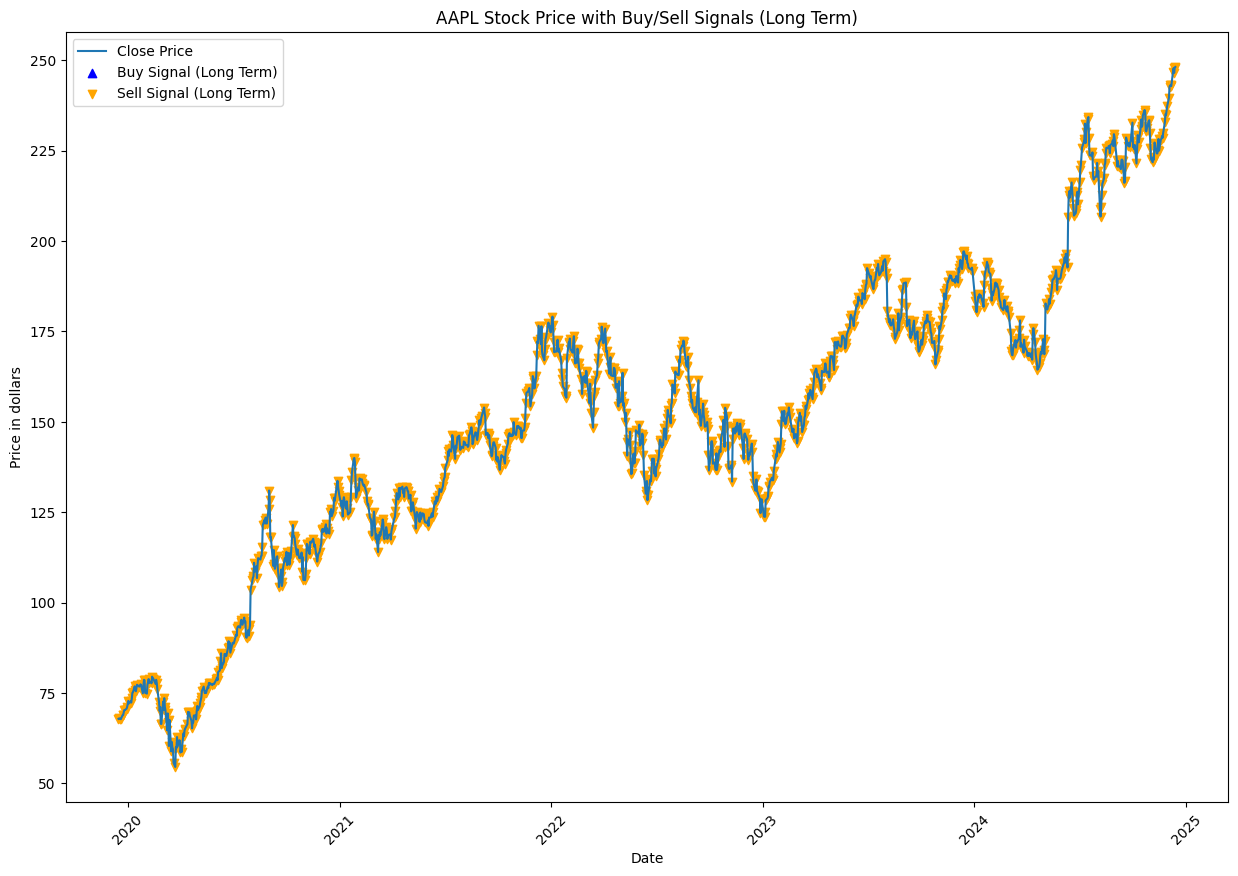

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Enter the stock name or ticker symbol: AAPL
Overall Sentiment for AAPL: Neutral
Average Sentiment Score: 0.38
The stock is showing a bullish behavior


In [43]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn import metrics
import joblib
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
import requests

def fetch_stock_data(symbol):
    # Fetch the stock data from Yahoo Finance
    ticker = yf.Ticker(symbol)
    df = ticker.history(period="5y")

    # Process the data to retain only the specified columns and remove timestamps
    df.reset_index(inplace=True)
    df = df[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']]
    df['Date'] = df['Date'].dt.date
    df['month'] = pd.to_datetime(df['Date']).dt.month  # Add this line to extract the month

    return df

def calculate_rsi(data, window=14):
    delta = data['Close'].diff()
    gain = (delta.where(delta > 0, 0)).fillna(0)
    loss = (-delta.where(delta < 0, 0)).fillna(0)
    avg_gain = gain.rolling(window=window).mean()
    avg_loss = loss.rolling(window=window).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    data['RSI'] = rsi
    return data

def calculate_macd(data, short_window=12, long_window=26, signal_window=9):
    data['EMA12'] = data['Close'].ewm(span=short_window, adjust=False).mean()
    data['EMA26'] = data['Close'].ewm(span=long_window, adjust=False).mean()
    data['MACD'] = data['EMA12'] - data['EMA26']
    data['Signal_Line'] = data['MACD'].ewm(span=signal_window, adjust=False).mean()
    return data

def calculate_bollinger_bands(data, window=20, num_std_dev=2):
    data['SMA'] = data['Close'].rolling(window=window).mean()
    data['STD'] = data['Close'].rolling(window=window).std()
    data['Upper_Band'] = data['SMA'] + (data['STD'] * num_std_dev)
    data['Lower_Band'] = data['SMA'] - (data['STD'] * num_std_dev)
    return data

def calculate_moving_averages(data, short_window=50, long_window=200, extra_long_window=500):
    data['SMA50'] = data['Close'].rolling(window=short_window).mean()
    data['SMA200'] = data['Close'].rolling(window=long_window).mean()
    data['SMA500'] = data['Close'].rolling(window=extra_long_window).mean()
    return data

def calculate_support_resistance(data, window=20):
    data['Support'] = data['Low'].rolling(window=window, min_periods=1).min()
    data['Resistance'] = data['High'].rolling(window=window, min_periods=1).max()
    return data

symbol = input('Enter the stock name or ticker symbol: ')
data = fetch_stock_data(symbol)

if not data.empty:
    data['is_quarter_end'] = np.where(data['month'] % 3 == 0, 1, 0)

    data = calculate_rsi(data)
    data = calculate_macd(data)
    data = calculate_bollinger_bands(data)
    data = calculate_moving_averages(data)
    data = calculate_support_resistance(data)

    # Additional columns
    data['open-close'] = data['Open'] - data['Close']
    data['low-high'] = data['Low'] - data['High']

    # Define the target variable for short term
    data['target_short_term'] = np.where(data['Close'].rolling(3).mean().shift(-1) > data['Close'], 1, 0)

    # Define the target variable for long term
    data['target_long_term'] = np.where(data['Close'].rolling(252).mean().shift(-1) > data['Close'], 1, 0)  # Approximately 1 year trading days

    # Features for both short-term and long-term models
    features = data[['open-close', 'low-high', 'is_quarter_end', 'RSI', 'MACD', 'Signal_Line', 'Upper_Band', 'Lower_Band', 'SMA50', 'SMA200', 'SMA500']]
    target_short_term = data['target_short_term']
    target_long_term = data['target_long_term']

    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)

    # Split data for short-term and long-term models
    X_train_short, X_valid_short, Y_train_short, Y_valid_short = train_test_split(features_scaled, target_short_term, test_size=0.2, random_state=2022)
    X_train_long, X_valid_long, Y_train_long, Y_valid_long = train_test_split(features_scaled, target_long_term, test_size=0.2, random_state=2022)

    # Train the XGBoost model for short term
    xgb_model_short = XGBClassifier(n_estimators=100, learning_rate=0.01, max_depth=3, random_state=2022)
    xgb_model_short.fit(X_train_short, Y_train_short)

    # Train the XGBoost model for long term
    xgb_model_long = XGBClassifier(n_estimators=150, learning_rate=0.001, max_depth=3, random_state=2022)
    xgb_model_long.fit(X_train_long, Y_train_long)

    print(f'{xgb_model_short} : ')
    print('Short Term Training Accuracy : ', metrics.roc_auc_score(Y_train_short, xgb_model_short.predict_proba(X_train_short)[:, 1]))
    print('Short Term Validation Accuracy : ', metrics.roc_auc_score(Y_valid_short, xgb_model_short.predict_proba(X_valid_short)[:, 1]))

    print(f'{xgb_model_long} : ')
    print('Long Term Training Accuracy : ', metrics.roc_auc_score(Y_train_long, xgb_model_long.predict_proba(X_train_long)[:, 1]))
    print('Long Term Validation Accuracy : ', metrics.roc_auc_score(Y_valid_long, xgb_model_long.predict_proba(X_valid_long)[:, 1]))

    # Save models and scaler
    joblib.dump(xgb_model_short, 'xgb_model_short.pkl')
    joblib.dump(xgb_model_long, 'xgb_model_long.pkl')
    joblib.dump(scaler, 'scaler.pkl')

    # Predict signals for short term
    data['signal_short'] = xgb_model_short.predict(features_scaled)
    data['predicted_price_short'] = np.where(data['signal_short'] == 1, data['Close'].shift(-1), data['Close'].shift(1))

    # Predict signals for long term
    data['signal_long'] = xgb_model_long.predict(features_scaled)
    data['predicted_price_long'] = np.where(data['signal_long'] == 1, data['Close'].shift(-252), data['Close'].shift(252))

    # Plot Buy/Sell signals for short term
    plt.figure(figsize=(15, 10))
    plt.plot(data['Date'], data['Close'], label='Close Price')
    buy_signals_short = data[data['signal_short'] == 1]
    sell_signals_short = data[data['signal_short'] == 0]
    plt.scatter(buy_signals_short['Date'], buy_signals_short['Close'], label='Buy Signal (Short Term)', marker='^', color='green')
    plt.scatter(sell_signals_short['Date'], sell_signals_short['Close'], label='Sell Signal (Short Term)', marker='v', color='red')
    plt.title(f'{symbol} Stock Price with Buy/Sell Signals (Short Term)')
    plt.xlabel('Date')
    plt.ylabel('Price in dollars')
    plt.legend()
    plt.xticks(rotation=45)
    plt.show()

      # Visualize actual vs predicted trends
    plt.figure(figsize=(15, 10))
    plt.plot(data['Date'], data['Close'], label='Actual Close Price', color='blue')
    plt.plot(data['Date'], data['predicted_price_short'], label='Predicted Price', color='red', linestyle='--')
    plt.title('Stock Price Prediction')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.xticks(rotation=45)
    plt.show()

     # Plotting the stock price with support and resistance levels
    plt.figure(figsize=(15, 10))
    plt.plot(data['Date'], data['Close'], label='Close Price')
    plt.plot(data['Date'], data['Support'], label='Support', linestyle='--', color='green')
    plt.plot(data['Date'], data['Resistance'], label='Resistance', linestyle='--', color='red')
    plt.title(f'{symbol} Stock Price with Support and Resistance Levels')
    plt.xlabel('Date')
    plt.ylabel('Price in dollars')
    plt.legend()
    plt.xticks(rotation=45)
    plt.show()

    # Plot Buy/Sell signals for long term
    plt.figure(figsize=(15, 10))
    plt.plot(data['Date'], data['Close'], label='Close Price')
    buy_signals_long = data[data['signal_long'] == 1]
    sell_signals_long = data[data['signal_long'] == 0]
    plt.scatter(buy_signals_long['Date'], buy_signals_long['Close'], label='Buy Signal (Long Term)', marker='^', color='blue')
    plt.scatter(sell_signals_long['Date'], sell_signals_long['Close'], label='Sell Signal (Long Term)', marker='v', color='orange')
    plt.title(f'{symbol} Stock Price with Buy/Sell Signals (Long Term)')
    plt.xlabel('Date')
    plt.ylabel('Price in dollars')
    plt.legend()
    plt.xticks(rotation=45)
    plt.show()

  # Download VADER lexicon
nltk.download('vader_lexicon')

# Initialize VADER SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

# Your Google News API key
api_key = 'ab44d0d9b4c74ac890b768fb39f647fc'

# Function to get news articles
def get_news(query, api_key, language='en', page_size=100):
    url = f'https://newsapi.org/v2/everything?q={query}&language={language}&pageSize={page_size}&apiKey={api_key}'
    response = requests.get(url)
    articles = response.json().get('articles', [])
    return articles

# Function to create a DataFrame from the articles
def create_dataframe(articles):
    df = pd.DataFrame(articles)
    return df

# Function to perform sentiment analysis
def analyze_sentiment(text):
    return sia.polarity_scores(text)

# Function to aggregate sentiment scores
def aggregate_sentiments(df):
    compound_scores = []

    for index, row in df.iterrows():
        title = row['title'] if row['title'] else ''
        description = row.get('description', '') if row.get('description') else ''
        content = row.get('content', '') if row.get('content') else ''
        combined_text = title + ' ' + description + ' ' + content

        sentiment = analyze_sentiment(combined_text)
        compound_scores.append(sentiment['compound'])

    avg_compound = sum(compound_scores) / len(compound_scores) if compound_scores else 0
    return avg_compound

# Function to classify the aggregated sentiment
def classify_sentiment(avg_compound):
    if avg_compound > 0.5:
        return "Strong Buy"
    elif avg_compound < -0.5:
        return "Strong Sell"
    else:
        return "Neutral"

# Main function
def main():
    query = input('Enter the stock name or ticker symbol: ')  # Ask for the stock name or ticker symbol
    articles = get_news(query, api_key)

    if articles:
        df = create_dataframe(articles)
        avg_compound = aggregate_sentiments(df)
        sentiment_classification = classify_sentiment(avg_compound)

        print(f'Overall Sentiment for {query}: {sentiment_classification}')
        print(f'Average Sentiment Score: {avg_compound:.2f}')
    else:
        print('No articles found.')

    print('The stock is showing a bullish behavior')

if __name__ == '__main__':
    main()

from google.colab import files

# Download the files
# files.download('xgb_model_short.pkl')
# files.download('xgb_model_long.pkl')
# files.download('scaler.pkl')


[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Mean Squared Error: 1.6901961853727283


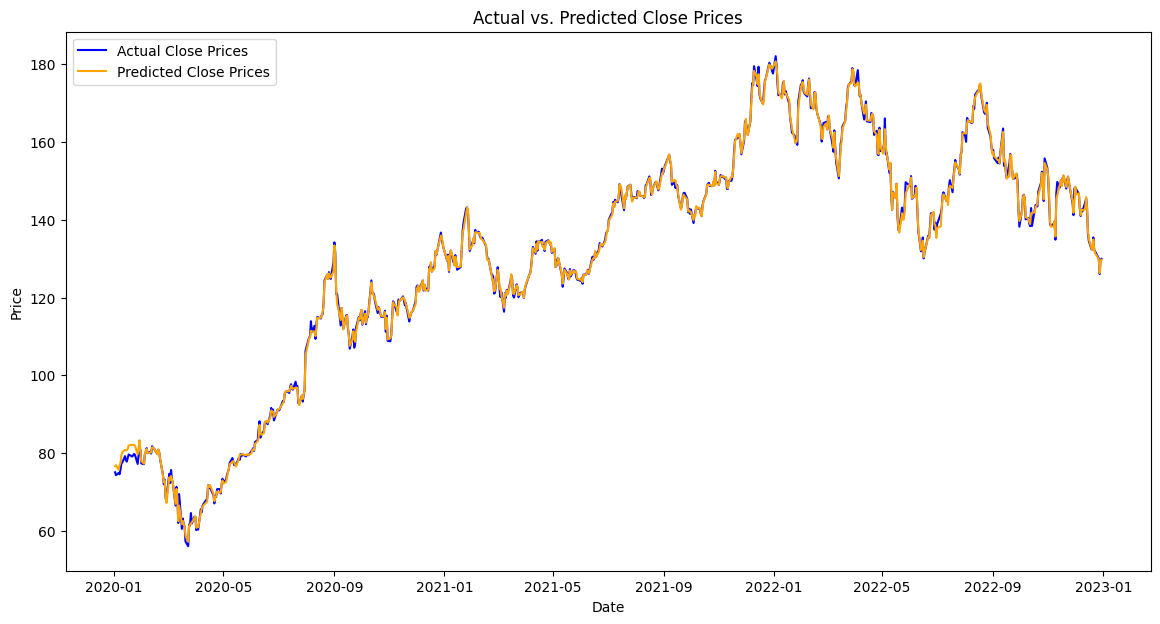

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import yfinance as yf

def fetch_stock_data(symbol, start_date, end_date):
    """Fetch stock data from Yahoo Finance."""
    data = yf.download(symbol, start=start_date, end=end_date)
    return data

def calculate_technical_indicators(stock_data):
    """Add technical indicators to the stock data."""
    # Simple Moving Average (SMA)
    stock_data['SMA_20'] = stock_data['Close'].rolling(window=20).mean()

    # Relative Strength Index (RSI)
    delta = stock_data['Close'].diff(1)
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    stock_data['RSI_14'] = 100 - (100 / (1 + rs))

    # Bollinger Bands
    sma = stock_data['Close'].rolling(window=20).mean()
    std = stock_data['Close'].rolling(window=20).std()
    stock_data['Bollinger_Upper'] = sma + (2 * std)
    stock_data['Bollinger_Lower'] = sma - (2 * std)

    return stock_data

def prepare_features(stock_data):
    """Prepare features and target for the model."""
    stock_data = stock_data.dropna()
    features = stock_data[['Open', 'High', 'Low', 'Volume', 'SMA_20', 'RSI_14', 'Bollinger_Upper', 'Bollinger_Lower']]
    target = stock_data['Close']
    return features, target

def train_random_forest(features, target):
    """Train a Random Forest Regressor."""
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    # Predictions and Evaluation
    predictions = model.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    print(f"Mean Squared Error: {mse}")

    return model

def plot_predictions(stock_data, model):
    """Plot actual vs. predicted stock prices."""
    features, target = prepare_features(stock_data)
    stock_data['Predicted_Close'] = model.predict(features)

    plt.figure(figsize=(14, 7))
    plt.plot(stock_data.index, stock_data['Close'], label='Actual Close Prices', color='blue')
    plt.plot(stock_data.index, stock_data['Predicted_Close'], label='Predicted Close Prices', color='orange')
    plt.title('Actual vs. Predicted Close Prices')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

# Main Execution
if __name__ == "__main__":
    # Input parameters
    symbol = "AAPL"  # Example: Apple stock
    start_date = "2020-01-01"
    end_date = "2023-01-01"

    # Fetch stock data
    stock_data = fetch_stock_data(symbol, start_date, end_date)

    # Add technical indicators
    stock_data = calculate_technical_indicators(stock_data)

    # Prepare features and target
    features, target = prepare_features(stock_data)

    # Train Random Forest model
    model = train_random_forest(features, target)

    # Plot predictions
    plot_predictions(stock_data, model)
